## Imports

In [1]:
import nltk
import pandas as pd
import re
import string
import seaborn as sns
import numpy as np
import dill

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

from matplotlib import pyplot as plt

In [3]:
from sklearn import set_config
set_config(print_changed_only = False)

%matplotlib inline

## Loading Data and EDA

In [4]:
train_df = pd.read_csv('Datasets/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_df = pd.read_csv('Datasets/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train_df.shape

(7613, 5)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

## Feature Engineering

### Hashtag Count

In [9]:
hashtag = r"#[a-zA-Z]\w+"
train_df['hashtag_count'] = train_df['text'].apply(lambda txt: len(re.findall(hashtag, txt)))
train_df.head()

,id,keyword,location,text,target,hashtag_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,2


In [10]:
test_df['hashtag_count'] = test_df['text'].apply(lambda txt: len(re.findall(hashtag, txt)))
test_df.head()

,id,keyword,location,text,hashtag_count
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,2
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0


In [11]:
train_df['hashtag_count'].describe()

count    7613.000000
mean        0.428609
std         1.073889
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        13.000000
Name: hashtag_count, dtype: float64

<AxesSubplot:xlabel='hashtag_count', ylabel='count'>

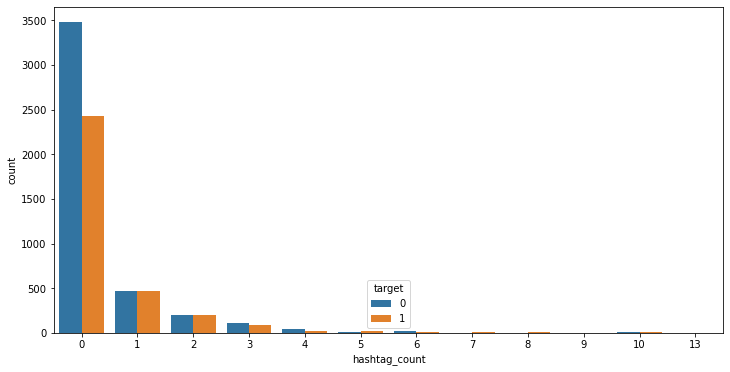

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(x= 'hashtag_count', hue='target', data = train_df)

### Keywords

In [13]:
train_df['keyword'].fillna(value = 'NaN', inplace = True)
test_df['keyword'].fillna(value = 'NaN', inplace = True)

print('Null value count for keywords in training dataset: ', train_df['keyword'].isnull().sum())
print('Null value count for keywords in testing dataset: ', test_df['keyword'].isnull().sum())

Null value count for keywords in training dataset:  0
Null value count for keywords in testing dataset:  0


In [14]:
kw_oe = OrdinalEncoder(dtype='int16')
kw_oe.fit(train_df[['keyword']])

OrdinalEncoder(categories='auto', dtype='int16')

In [15]:
train_df['keyword'] = kw_oe.transform(train_df[['keyword']])
train_df.head()

,id,keyword,location,text,target,hashtag_count
0,1,0,NaN,Our Deeds are the Reason of this #earthquake M...,1,1
1,4,0,NaN,Forest fire near La Ronge Sask. Canada,1,0
2,5,0,NaN,All residents asked to 'shelter in place' are ...,1,0
3,6,0,NaN,"13,000 people receive #wildfires evacuation or...",1,1
4,7,0,NaN,Just got sent this photo from Ruby #Alaska as ...,1,2


In [16]:
test_df.loc[~test_df['keyword'].isin(kw_oe.categories_[0]), "keyword"] = 'NaN'
test_df['keyword'] = kw_oe.transform(test_df[['keyword']])
test_df.head()

,id,keyword,location,text,hashtag_count
0,0,0,NaN,Just happened a terrible car crash,0
1,2,0,NaN,"Heard about #earthquake is different cities, s...",1
2,3,0,NaN,"there is a forest fire at spot pond, geese are...",0
3,9,0,NaN,Apocalypse lighting. #Spokane #wildfires,2
4,11,0,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0


### Length of text

In [17]:
train_df['text_len'] = train_df['text'].apply(lambda x: len(x) - x.count(" "))
train_df.head()

,id,keyword,location,text,target,hashtag_count,text_len
0,1,0,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,57
1,4,0,NaN,Forest fire near La Ronge Sask. Canada,1,0,32
2,5,0,NaN,All residents asked to 'shelter in place' are ...,1,0,112
3,6,0,NaN,"13,000 people receive #wildfires evacuation or...",1,1,57
4,7,0,NaN,Just got sent this photo from Ruby #Alaska as ...,1,2,72


In [18]:
test_df['text_len'] = test_df['text'].apply(lambda x: len(x) - x.count(" "))
test_df.head()

,id,keyword,location,text,hashtag_count,text_len
0,0,0,NaN,Just happened a terrible car crash,0,29
1,2,0,NaN,"Heard about #earthquake is different cities, s...",1,56
2,3,0,NaN,"there is a forest fire at spot pond, geese are...",0,78
3,9,0,NaN,Apocalypse lighting. #Spokane #wildfires,2,37
4,11,0,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0,38


In [19]:
train_df['text_len'].describe()

count    7613.000000
mean       87.108499
std        29.151660
min         6.000000
25%        67.000000
50%        92.000000
75%       114.000000
max       138.000000
Name: text_len, dtype: float64

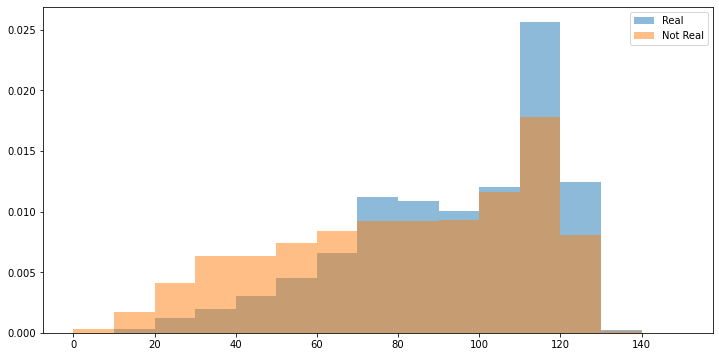

In [20]:
bins = np.linspace(0, 150, 16)

plt.figure(figsize = (12, 6))
plt.hist(train_df[train_df['target'] == 1]['text_len'], bins, alpha = 0.5, density = True, label = 'Real')
plt.hist(train_df[train_df['target'] == 0]['text_len'], bins, alpha = 0.5, density = True, label = 'Not Real')
plt.legend()
plt.show()

### Word count

In [21]:
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

In [22]:
def tokenize_text(text):
    text = text.lower()
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('[^a-z]+', text)
    return tokens

def clean_text(tokens):
    text = [wn.lemmatize(word) for word in tokens if not (word in stopwords or str.isspace(word) or len(word)==0)]
    return text 

In [23]:
train_df['text'] = train_df['text'].apply(lambda txt: tokenize_text(txt))
train_df['word_count'] = train_df['text'].apply(lambda tokens: len(tokens))
train_df.head()

,id,keyword,location,text,target,hashtag_count,text_len,word_count
0,1,0,NaN,"[our, deeds, are, the, reason, of, this, earth...",1,1,57,13
1,4,0,NaN,"[forest, fire, near, la, ronge, sask, canada]",1,0,32,7
2,5,0,NaN,"[all, residents, asked, to, shelter, in, place...",1,0,112,22
3,6,0,NaN,"[, people, receive, wildfires, evacuation, ord...",1,1,57,9
4,7,0,NaN,"[just, got, sent, this, photo, from, ruby, ala...",1,2,72,17


In [24]:
test_df['text'] = test_df['text'].apply(lambda txt: tokenize_text(txt))
test_df['word_count'] = test_df['text'].apply(lambda tokens: len(tokens))
test_df.head()

,id,keyword,location,text,hashtag_count,text_len,word_count
0,0,0,NaN,"[just, happened, a, terrible, car, crash]",0,29,6
1,2,0,NaN,"[heard, about, earthquake, is, different, citi...",1,56,9
2,3,0,NaN,"[there, is, a, forest, fire, at, spot, pond, g...",0,78,19
3,9,0,NaN,"[apocalypse, lighting, spokane, wildfires]",2,37,4
4,11,0,NaN,"[typhoon, soudelor, kills, in, china, and, tai...",0,38,7


In [25]:
train_df['word_count'].describe()

count    7613.000000
mean       15.382372
std         5.660104
min         1.000000
25%        11.000000
50%        16.000000
75%        20.000000
max        31.000000
Name: word_count, dtype: float64

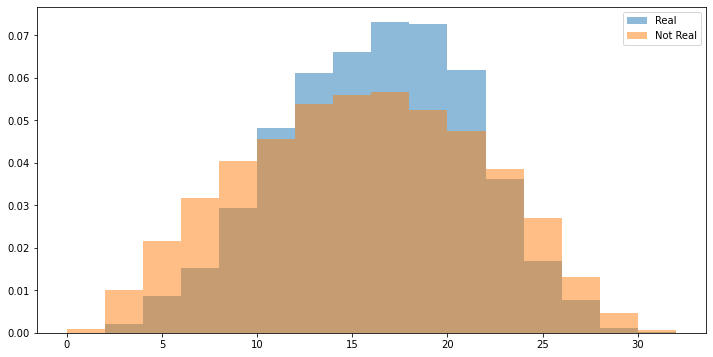

In [26]:
bins = np.linspace(0, 32, 17)

plt.figure(figsize = (12, 6))
plt.hist(train_df[train_df['target'] == 1]['word_count'], bins, alpha = 0.5, density = True, label = 'Real')
plt.hist(train_df[train_df['target'] == 0]['word_count'], bins, alpha = 0.5, density = True, label = 'Not Real')
plt.legend()
plt.show()

### TF-IDF

In [27]:
tfidf_vect = TfidfVectorizer(analyzer= clean_text)
tfidf_vect_fit = tfidf_vect.fit(train_df['text'])

In [28]:
tfidf_vect_columns = ['tf_' + colname for colname in tfidf_vect.get_feature_names()]
tfidf_vect_columns[::1000]

['tf_aa',
 'tf_autism',
 'tf_btwn',
 'tf_compensate',
 'tf_diary',
 'tf_escape',
 'tf_funemes',
 'tf_hew',
 'tf_httptcodknlznom',
 'tf_httptcomjfdcrjs',
 'tf_httptcovpqtgeqlma',
 'tf_investigative',
 'tf_kvzbn',
 'tf_mayoroflondon',
 'tf_nft',
 'tf_pbc',
 'tf_quarter',
 'tf_rymfjcux',
 'tf_soonersportstv',
 'tf_thankfully',
 'tf_uphill',
 'tf_worstever']

In [29]:
train_tf_df = pd.DataFrame(tfidf_vect_fit.transform(train_df['text']).toarray(), columns = tfidf_vect_columns)
train_tf_df.head()

,tf_aa,tf_aaaa,tf_aaaaaaallll,tf_aaaaaand,tf_aaarrrgghhh,tf_aaceorg,tf_aag,tf_aal,tf_aampb,tf_aampw,...,tf_zykct,tf_zynp,tf_zz,tf_zzbha,tf_zzcupnz,tf_zzk,tf_zznbvfuvo,tf_zzr,tf_zzuz,tf_zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
test_tf_df = pd.DataFrame(tfidf_vect_fit.transform(test_df['text']).toarray(), columns = tfidf_vect_columns)
test_tf_df.head()

,tf_aa,tf_aaaa,tf_aaaaaaallll,tf_aaaaaand,tf_aaarrrgghhh,tf_aaceorg,tf_aag,tf_aal,tf_aampb,tf_aampw,...,tf_zykct,tf_zynp,tf_zz,tf_zzbha,tf_zzcupnz,tf_zzk,tf_zznbvfuvo,tf_zzr,tf_zzuz,tf_zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Random Forest Classifier

In [31]:
X_features = pd.concat([train_df[['keyword', 'hashtag_count', 'text_len', 'word_count']], train_tf_df], axis = 1)
X_features.shape

(7613, 21749)

In [32]:
Y_label = train_df['target']
Y_label.shape

(7613,)

In [33]:
rf = RandomForestClassifier(random_state = 7)
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

### Hyperparameter tuning using GridSearchCV

In [34]:
param = {'n_estimators': [50, 100, 150],
        'max_depth': [30, 60, 90, None]}

k_fold = KFold(n_splits = 5)

gs = GridSearchCV(rf, param, cv = k_fold)
gs_fit = gs.fit(X_features, Y_label)
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,62.354631,1.338291,0.446918,0.019763,None,150,"{'max_depth': None, 'n_estimators': 150}",0.760998,0.724885,0.663165,0.683968,0.739816,0.714566,0.035995,1
9,21.379715,0.442764,0.304181,0.006525,None,50,"{'max_depth': None, 'n_estimators': 50}",0.753775,0.725542,0.663821,0.674770,0.743101,0.712202,0.036340,2
10,41.561904,1.001084,0.370913,0.015412,None,100,"{'max_depth': None, 'n_estimators': 100}",0.750492,0.722915,0.661195,0.679369,0.744415,0.711677,0.035488,3
8,31.819350,0.233709,0.318049,0.004299,90,150,"{'max_depth': 90, 'n_estimators': 150}",0.745896,0.718976,0.649376,0.683968,0.722733,0.704190,0.033809,4
7,21.433759,0.204284,0.297672,0.018063,90,100,"{'max_depth': 90, 'n_estimators': 100}",0.741957,0.713066,0.644123,0.687254,0.725361,0.702352,0.034151,5


In [35]:
gs_fit.best_params_

{'max_depth': None, 'n_estimators': 150}

In [36]:
X_test_features = pd.concat([test_df[['keyword', 'hashtag_count', 'text_len', 'word_count']], test_tf_df], axis = 1)
X_test_features.shape

(3263, 21749)

In [37]:
y_hat = gs_fit.predict(X_test_features)
y_hat.shape

(3263,)

In [38]:
test_df = pd.concat([test_df, pd.DataFrame(y_hat, columns=['target'])], axis = 1)
test_df.head()

,id,keyword,location,text,hashtag_count,text_len,word_count,target
0,0,0,NaN,"[just, happened, a, terrible, car, crash]",0,29,6,0
1,2,0,NaN,"[heard, about, earthquake, is, different, citi...",1,56,9,1
2,3,0,NaN,"[there, is, a, forest, fire, at, spot, pond, g...",0,78,19,1
3,9,0,NaN,"[apocalypse, lighting, spokane, wildfires]",2,37,4,0
4,11,0,NaN,"[typhoon, soudelor, kills, in, china, and, tai...",0,38,7,1


In [39]:
submission_df = test_df[['id', 'target']]
submission_df.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [40]:
submission_df.to_csv('disaster_tweet_nlp_mayur.csv', index=False)

## Model Pickling

### Keyword Ordinal Encoder

In [41]:
with open('Models/kw_oe.pkl', 'wb') as file:
    dill.dump(kw_oe, file)

### TF-IDF Vectorizer

In [42]:
with open('Models/tfidf.pkl', 'wb') as file:
    dill.dump(tfidf_vect_fit, file)

### Random Forest Model

In [43]:
with open('Models/rf.pkl', 'wb') as file:
    dill.dump(gs_fit.best_estimator_, file)